In [1]:
import tensorflow as tf # version 2.18
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.python import keras
from keras import layers, callbacks, models # from tensorflow.keras
from keras import preprocessing
from keras import optimizers
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [6]:
# additional_columns_1 = pd.read_csv('./data/0_TO_3000.csv', index_col=0)
# additional_columns_2 = pd.read_csv('./data/3000_TO_6000.csv', index_col=0)
# additional_columns_3 = pd.read_csv('./data/6000_TO_10000.csv', index_col=0)
# additional_columns_4 = pd.read_csv('./data/10000_TO_13000.csv', index_col=0)
# additional_columns_5 = pd.read_csv('./data/13000_TO_16000.csv', index_col=0)
# additional_columns_6 = pd.read_csv('./data/16000_TO_20000.csv', index_col=0)
# additional_columns_7 = pd.read_csv('./data/20000_TO_23000.csv', index_col=0)
# additional_columns_8 = pd.read_csv('./data/23000_TO_26000.csv', index_col=0)
# additional_data = pd.concat([additional_columns_1, additional_columns_2, additional_columns_3, additional_columns_4, additional_columns_5, additional_columns_6, additional_columns_7, additional_columns_8], axis=0)
# additional_data.shape[0]
# additional_data.to_csv('./data/additional_nofire_data.csv')

In [2]:
data = pd.read_csv('./Data/merged.csv', index_col=0) # ./Data/new_data_equal_proportions_randomized_elevation.csv
#data_2 = pd.read_csv('./data/additional_nofire_data.csv', index_col=0)
#data = pd.concat([data, data_2], axis=0)
data = data.loc[data.TEMP_MAX != 0.0]
data = data.loc[~data.NDVI.isnull()]

data.drop(['AVG_100M_WIND', 'YEAR', 'CLOUD_HIGH', 'CLOUD_MID', 'CLOUD', 'AVG_WEATHER_CONDITION', 'APPARENT_TEMP', 'TEMP_MIN', 'AVG_PRECIPITATION'], axis=1, inplace=True)

X = data.copy()
X = X.sample(frac=1) # shuffle rows

X.dropna(subset=['fire'], axis=0, inplace=True)
y = X.fire 
X.drop(['fire'], axis=1, inplace=True)

X.head()

,LATDD83,LONGDD83,MONTH,DAY,TEMP_MAX,AVG_RELATIVE_HUMIDITY,AVG_10M_WIND,CLOUD_LOW,AVG_SOIL_TEMP,AVG_SOIL_MOISTURE,ELEVATION,NDVI
34709,40.689505,-104.711303,12,20,49.624702,26.762754,10.918030,0.000000,31.849701,0.117500,1552.0,0.1902
13112,45.135030,-116.638610,7,2,78.311302,42.170307,7.944318,0.000000,64.260048,0.195375,2140.0,0.7695
4281,48.247390,-109.719120,4,24,54.852798,55.083359,15.190440,1.666667,40.850300,0.365000,1212.0,0.3698
5227,34.245490,-117.867870,12,2,62.396599,50.392300,5.569032,0.000000,50.216602,0.219750,508.0,0.5046
37644,48.338859,-104.630817,11,7,52.127602,67.495506,12.070046,3.375000,43.063854,0.227875,585.0,0.2132


In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [4]:
X.dtypes

LATDD83                  float64
LONGDD83                 float64
MONTH                      int64
DAY                        int64
TEMP_MAX                 float64
AVG_RELATIVE_HUMIDITY    float64
AVG_10M_WIND             float64
CLOUD_LOW                float64
AVG_SOIL_TEMP            float64
AVG_SOIL_MOISTURE        float64
ELEVATION                float64
NDVI                     float64
dtype: object

In [5]:
numerical_columns = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
categorical_columns = [col for col in X.columns if X[col].dtype in ['category', 'object']] # There's literally no categorical columns here but it's good practice

numerical_transformer = make_pipeline(
    SimpleImputer(strategy='constant'),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessor = make_column_transformer(
    (numerical_transformer, numerical_columns),
    (categorical_transformer, categorical_columns)
)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

In [6]:
model = models.Sequential([
    layers.BatchNormalization(input_shape = [X_train.shape[1]]),
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(units=1, activation='sigmoid')
])

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=25, restore_best_weights=True)

Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - binary_accuracy: 0.6794 - loss: 0.6888 - val_binary_accuracy: 0.7557 - val_loss: 0.5963
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_accuracy: 0.7452 - loss: 0.5326 - val_binary_accuracy: 0.7771 - val_loss: 0.5458
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7591 - loss: 0.5016 - val_binary_accuracy: 0.7805 - val_loss: 0.5067
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7679 - loss: 0.4877 - val_binary_accuracy: 0.7857 - val_loss: 0.4801
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7737 - loss: 0.4730 - val_binary_accuracy: 0.7922 - val_loss: 0.4589
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7818 - loss: 0.4690 - val_binary_accuracy: 0.7949 - val_loss: 0.4446
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7828 - loss: 0.4627 - val_binary_accuracy: 0.7965 - val_loss: 0.4345
Epoch 

<Axes: >

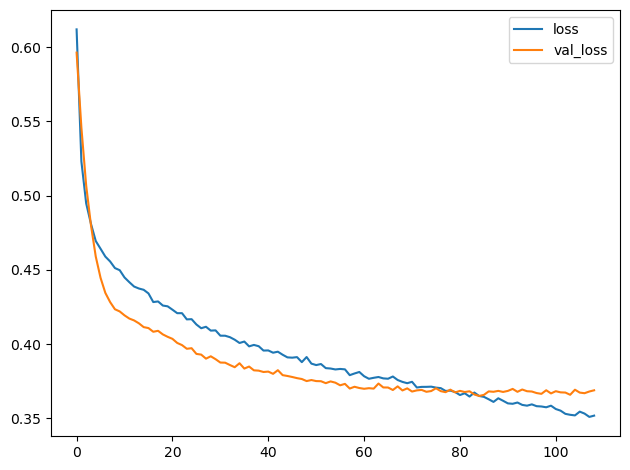

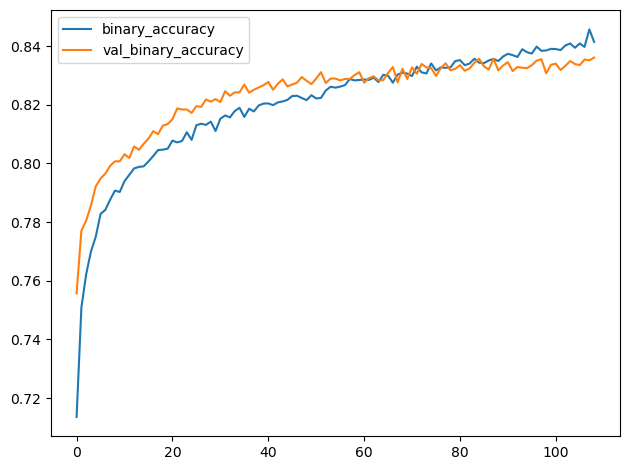

In [8]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=512, epochs=200, callbacks=[early_stopping])

df = pd.DataFrame(history.history)
df.loc[:, ['loss', 'val_loss']].plot()
df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [9]:
from sklearn.feature_selection import mutual_info_regression

def get_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(['category', 'object']):
        X[colname], _ = X[colname].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    scores = pd.Series(scores, name='mi_scores', index=X.columns)
    scores = scores.sort_values(ascending=False)
    return scores

get_mi_scores(X, y)

NDVI                     0.138707
TEMP_MAX                 0.099883
MONTH                    0.086042
AVG_SOIL_TEMP            0.084873
LONGDD83                 0.083396
AVG_SOIL_MOISTURE        0.057397
LATDD83                  0.050719
AVG_10M_WIND             0.039356
DAY                      0.038753
AVG_RELATIVE_HUMIDITY    0.029129
CLOUD_LOW                0.027005
ELEVATION                0.013487
Name: mi_scores, dtype: float64

In [10]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_valid)

for i in range(len(y_pred)):
    if y_pred[i] < 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1

print(classification_report(y_valid, y_pred))

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4035
           1       0.82      0.84      0.83      3828

    accuracy                           0.83      7863
   macro avg       0.83      0.83      0.83      7863
weighted avg       0.83      0.83      0.83      7863

